In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Reinforcement Learning

## Session 04c: Planning by DP


##  Frozen Lake with Temporal Differencing

    
<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# import statements

import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt

from collections import defaultdict
from tqdm import tqdm, trange

import seaborn as sns
import time

from IPython.display import clear_output, display

%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'

RANDOM_STATE = 24
EPISODES = 50000

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)


SMALL_ENOUGH = 1e-3

GAMMA = 0.99

ALPHA = 0.01

## Environment - FrozenLake-v1

Fronze Lake is a simple game where Actor is on a frozen lake and need to reach a **Goal** on the frozen lake. Some parts of lake are frozen solid and some parts have holes. If Actor walk into a hole, game over!

Actions: $A$ ={0,1,2,3}

    LEFT: 0
    DOWN = 1
    RIGHT = 2
    UP = 3

Whole lake is a 4 x 4 grid world. 
States $S$ are from 0 to 15

SFFF      (S: starting point, safe)<br>
FHFH      (F: frozen surface, safe)<br>
FFFH      (H: hole, fall to your doom)<br>
HFFG      (G: goal, where the frisbee is located)<br>

In [4]:
# Action mappings - Map actions to numbers
action_mappings = {
    0: '\u2190' , # Left
    1: '\u2193', # Down
    2: '\u2192', # Right
    3: '\u2191', # Up
}

print (action_mappings)

{0: '←', 1: '↓', 2: '→', 3: '↑'}


In [5]:
# Function a Random Policy
def random_policy(env):
    '''
    Args:
        env: Environment
    Return:
        Policy : A dict containg random policy
    '''

    return np.random.randint(0, env.action_space.n, size=env.observation_space.n)

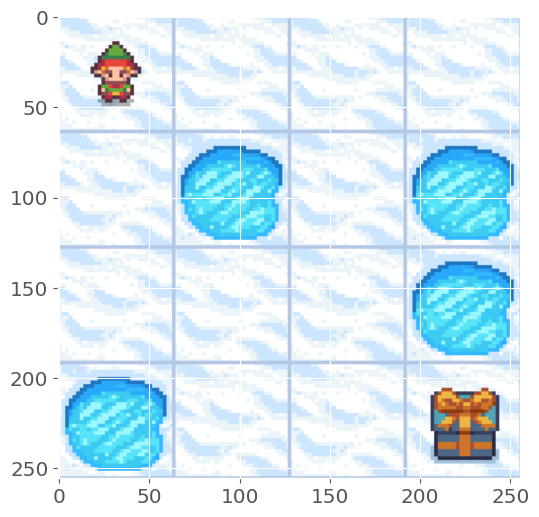

In [6]:
# Make the environment based on non-deterministic policy
env = gym.make('FrozenLake-v1', render_mode='rgb_array', is_slippery=True)

env.reset(seed = RANDOM_STATE)

img = plt.imshow(env.render())

In [7]:
pol = random_policy(env)
pol.shape

(16,)

1 False False {'prob': 0.3333333333333333}


/home/pks/RL/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


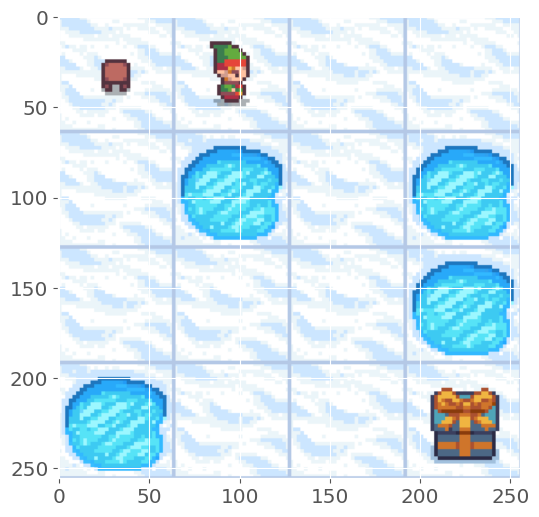

In [8]:
# Go right once (action = 2), we should go to the right but we did not!
env.reset()

action = 2

observation, reward, terminated, truncated, prob = env.step(action)

img = plt.imshow(env.render())

print (observation, terminated, truncated, prob)

2 False False {'prob': 0.3333333333333333}


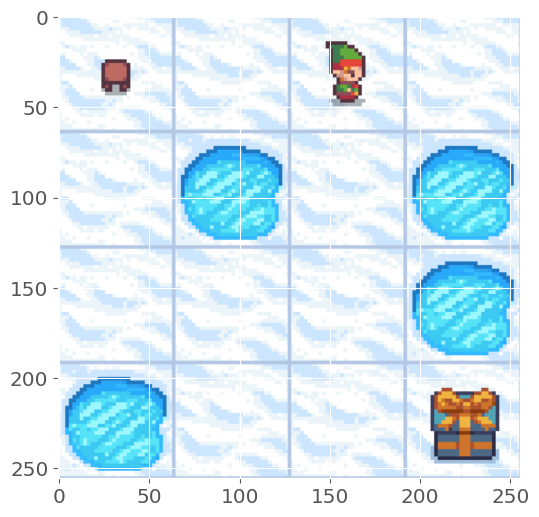

In [9]:
# Repeat the action

action = 2

observation, reward, terminated, truncated, prob = env.step(action)

img = plt.imshow(env.render())

print (observation, terminated, truncated, prob)

In [10]:
# Define a function to generate epsiodes
def generate_episode(policy, env):
    '''
    Args:
        policy : policy dict
        env: Environment
    Return:
    List of states, actions, rewards
        states: list of states cisited
    '''
    
    
    # we initialize the list for storing states, actions, and rewards
    states, actions, rewards = [], [], []
    
    # Initialize the gym environment
    observation = env.reset()[0]
    
    while True:
        
        # append the states to the states list
        states.append(observation)
        
        # Action from random policy
        action = policy[observation]
        actions.append(action)
        
        # Take Acton
        observation, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        
        # Break if the state is a terminal state
        done = terminated or truncated
        
        if done:
            #print (done, terminated , truncated, observation)
            break
                
                
    return states, actions, rewards

In [11]:
policy = random_policy(env)

states, actions, rewards  = generate_episode(policy, env)

 Now that we learned how to generate an episode, we will see how to perform First Vist MC Prediction

In [12]:
def td_prediction(policy, env, n_episodes):
    
    # Initialize value table as a dictionary for storing the values of each state
    value_table = defaultdict(float)

    
    for _ in trange(n_episodes):
        
        # Play game to get sequence of actions and rewards
        states, _, rewards = generate_episode(policy, env)
        
        # Then for each step, we store the rewards to a variable R and states to S, and we calculate
        # returns as a sum of rewards
        
        for t in range(len(states) - 1): # for all states in this sequence
            reward = rewards[t+1] # retrive reward  
            next_state = states[t+1] # retrive next_state
            cur_state = states[t]
            
            value_table[cur_state] = (value_table[cur_state] + 
                                      ALPHA * ( reward +
                                               GAMMA * value_table[next_state] -
                                               value_table[cur_state]))
            
    return value_table

In [13]:
# Execute for some episodes and get values

n_episodes= EPISODES #50000

value = td_prediction(policy, env, n_episodes=n_episodes)

100%|██████████████████████████████████| 50000/50000 [00:03<00:00, 14587.05it/s]


In [14]:
value

defaultdict(float,
            {0: 1.0163972995261445,
             4: 1.073373180473036,
             1: 0.9926453918611186,
             8: 1.1664755966417124,
             9: 1.2053839290923543,
             10: 1.2915552812949496,
             6: 0.9752450275584384,
             14: 1.4536539943235807,
             2: 0.8045840224382802})

In [15]:
def fn_get_optimal_policy(grid, V):
    
    # Find the optimal policy corresponding to the optimal value function
    policy = np.zeros((grid.observation_space.n, grid.action_space.n))

    for state in range(grid.observation_space.n):
        
        # Create a vector of dimensionality same as the number of actions
        action_values = np.zeros(grid.action_space.n)

        for action in range(grid.action_space.n):

            for probability, next_state, reward, terminated in grid.P[state][action]:
                
                action_values[action] += probability * (reward + GAMMA * V[next_state])
                #action_values = one_step_lookahead(environment, state, action_values, discount_factor)

        # Choose the best action
        best_action = np.argmax(action_values)
        
        #print ('State :', state, action_values, best_action)

        policy[state][best_action] = 1.0

    return policy

In [16]:
policy = fn_get_optimal_policy(env, value)
policy

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.]])

In [17]:
plot_grid = np.zeros((4,4))

for k in value.keys():
    i = k //4
    j = k %4
    plot_grid[i,j] = value[k]
plot_grid

array([[1.0163973 , 0.99264539, 0.80458402, 0.        ],
       [1.07337318, 0.        , 0.97524503, 0.        ],
       [1.1664756 , 1.20538393, 1.29155528, 0.        ],
       [0.        , 0.        , 1.45365399, 0.        ]])

In [18]:
# Helper function to plot the grid

def fn_plot_heatmap(values, policy):
    fig, axes = plt.subplots(1,2)
    act = [action_mappings[action] for action in np.argmax(policy, axis=1)]
    labels = np.asarray(["{0}\n{1:.3f}".format(a, v)
                          for a, v in zip(act,values.ravel())]).reshape(4,4)
    #values = values.reshape(8,8)
    sns.heatmap(values, annot=labels, fmt="", cmap='RdYlGn', ax=axes[0])
    axes[1].imshow(env.render())
    plt.show()

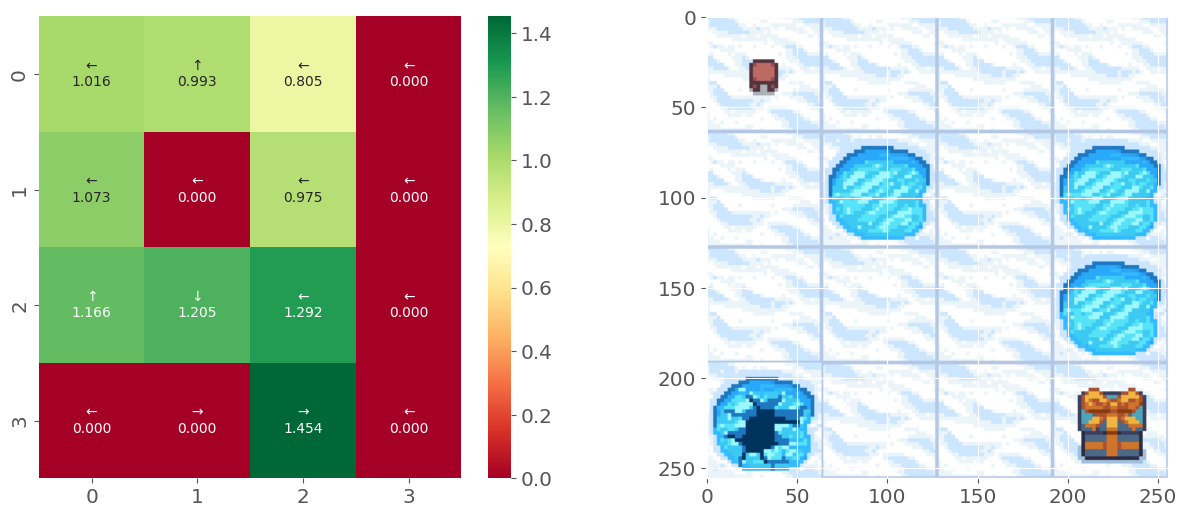

In [19]:
fn_plot_heatmap(plot_grid, policy)

In [20]:
n_iteration = 1000

highscore = 0

data_row = []

for n_iter in trange(n_iteration):

    points = 0 # keep track of the reward each episode
    
    data_dict = {}
    
    for i_episode in range(20): # run 20 episodes
        
        observation = env.reset()[0]
        
        while True: # run until episode is done
            
            action = np.argmax(policy[observation])
            
            observation, reward, terminated, truncated, info = env.step(action)
    
            points += reward
            
            done = terminated or truncated
            if done:
                #env.render()
                #print ('Iteration', n_iter, observation, reward, done, info)

                if points > highscore: # record high score
                    highscore = points
                break
    data_dict['run'] = n_iter
    data_dict['Points']=  points
    data_row.append(data_dict)

100%|██████████████████████████████████████| 1000/1000 [00:08<00:00, 122.64it/s]


In [21]:
results_df =  pd.DataFrame(data_row)
results_df.head()

,run,Points
0,0,11.0
1,1,14.0
2,2,14.0
3,3,15.0
4,4,13.0


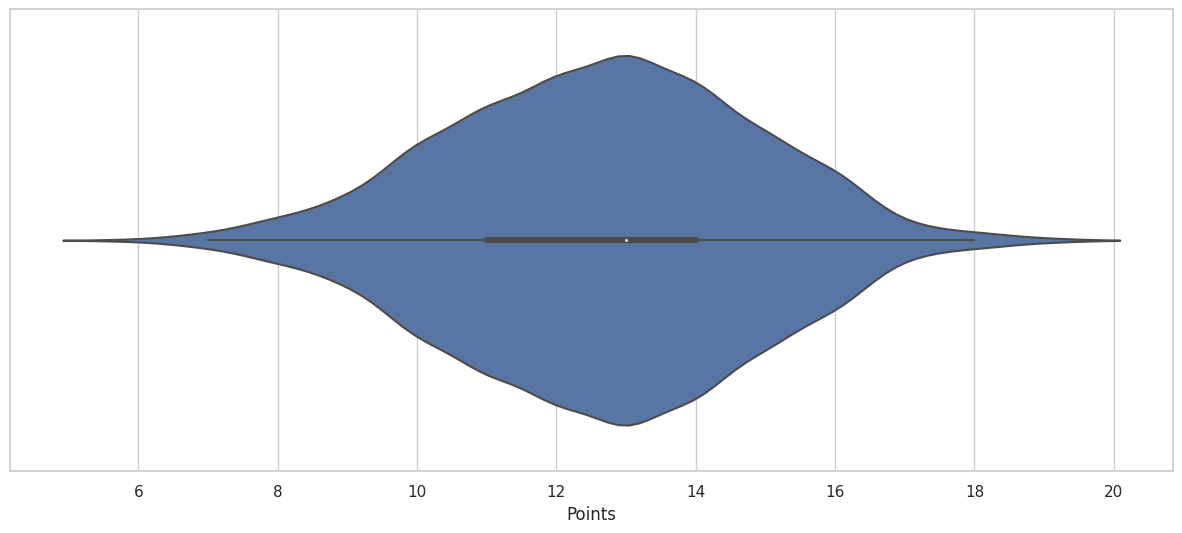

In [22]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=results_df["Points"])